# Credit Card Fraud Detection based on Kaggle dataset

## Model description:
++Transaction Table 

	+ Data Desc:
		- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
			timedelta from a given reference datetime (not an actual timestamp)
			“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”
		- TransactionAMT: transaction payment amount in USD
			“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”
		- ProductCD: product code, the product for each transaction
			product code, the product for each transaction
			“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”
		- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
		- addr: address
			“both addresses are for purchaser
			addr1 as billing region
			addr2 as billing country”
		- dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.
		- P_ and (R__) emaildomain: purchaser and recipient email domain “ certain transactions don't need recipient, so Remaildomain is null.”
		- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
			“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.
			Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”
		- D1-D15: timedelta, such as days between previous transaction, etc.
		- M1-M9: match, such as names on card and address, etc.
		- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
			"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

	+ Categorical Features:
		ProductCD
		card1 - card6
		addr1, addr2
		Pemaildomain Remaildomain
		M1 - M9

++Identity Table *

	+ Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
	They're collected by Vesta’s fraud protection system and digital security partners.
	(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

	+ Categorical Features:
		- DeviceType
		- DeviceInfo
		- id12 - id38
			“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

	+ Labeling logic
		"The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).
		However, in real world fraudulent activity might not be reported, e.g. cardholder was unaware, or forgot to report in time and beyond the claim period, etc. In such cases, supposed fraud might be labeled as legit, but we never could know of them. Thus, we think they're unusual cases and negligible portion." Read more : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#58895

# Import Libraries

In [161]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

test_identity = load_data('data/test_identity.csv')
test_transaction = load_data('data/test_transaction.csv')
train_identity = load_data('data/train_identity.csv')
train_transaction = load_data('data/train_transaction.csv')


Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


# Visualization of the Dataset

In [9]:
test_identity.shape, test_transaction.shape, train_identity.shape, train_transaction.shape

((141907, 41), (506691, 393), (144233, 41), (590540, 394))

In [14]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [15]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


visualisation inspired by: https://www.kaggle.com/sundaramoorthyks/base-model-logistic-regression

the density of TransactionDT

Text(0,0.5,'Counts')

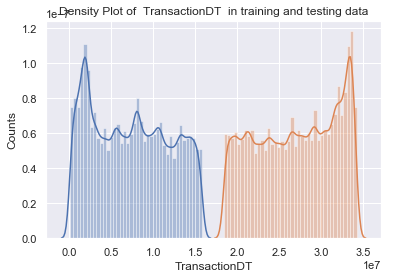

In [172]:
sns.distplot(train_transaction['TransactionDT'], hist=True, kde=True,bins=40) # its shows histogram along with the density plot
sns.distplot(test_transaction['TransactionDT'],hist=True,kde=True,bins=40)
plt.title('Density Plot of  TransactionDT  in training and testing data')
plt.xlabel('TransactionDT')
plt.ylabel('Counts')

In [ ]:
the density of Transaction Amount

Text(0,0.5,'Counts')

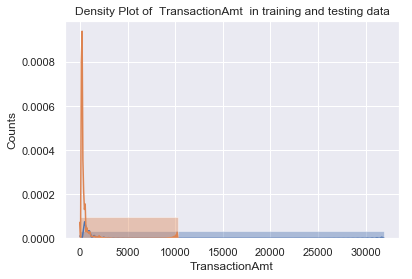

In [173]:
sns.distplot(train_transaction['TransactionAmt'], hist=True, kde=True,bins=1) # its shows histogram along with the density plot
sns.distplot(test_transaction['TransactionAmt'],hist=True,kde=True,bins=1)
plt.title('Density Plot of  TransactionAmt  in training and testing data')
plt.xlabel('TransactionAmt')
plt.ylabel('Counts')

analysis of Fraud/Non-Fraud vs Transaction Amount

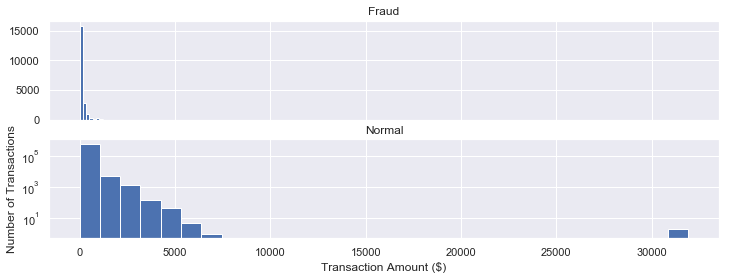

In [175]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(train_transaction.TransactionAmt[train_transaction.isFraud == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(train_transaction.TransactionAmt[train_transaction.isFraud == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

analysis of other train_transaction features

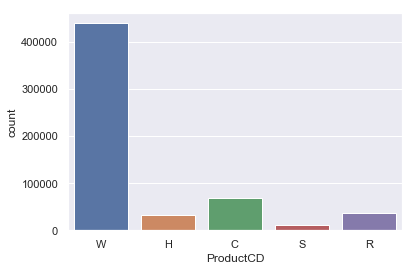

In [215]:
# shows the count in each class
sns.countplot(x="ProductCD", data=train_transaction) 

In [216]:
#categorical variable -ALL the cards
for col in ['card1','card2','card3','card4','card5','card6']:
    print("Feature count of " + str(col))
    feature_count=(train_transaction[col].value_counts())
    print(feature_count.head(4))

Feature count of card1
7919     14932
9500     14162
15885    10361
17188    10344
Name: card1, dtype: int64
Feature count of card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
Name: card2, dtype: int64
Feature count of card3
150.0    521287
185.0     56346
106.0      1571
146.0      1252
Name: card3, dtype: int64
Feature count of card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
Feature count of card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
Name: card5, dtype: int64
Feature count of card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64


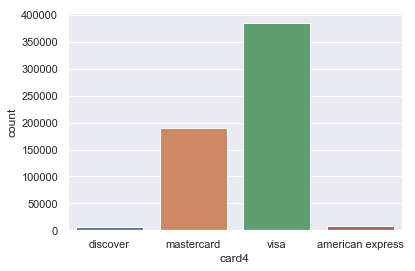

In [219]:
#card4-types of card
sns.countplot(train_transaction['card4'])

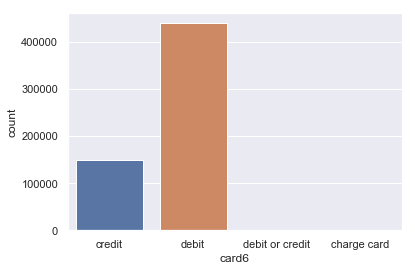

In [217]:
# card 6-type of card
sns.countplot(x=train_transaction['card6'])

In [220]:
#check how many transaction amount are in each types of card4
print(train_transaction.groupby('card4')['TransactionAmt'].mean())

card4
american express    173.000
discover            265.750
mastercard          132.375
visa                133.125
Name: TransactionAmt, dtype: float16


In [221]:
#check how many transaction amount are in each types of card6
print(train_transaction.groupby('card6')['TransactionAmt'].mean()) 

card6
charge card         59.53125
credit             190.00000
debit              116.31250
debit or credit    104.06250
Name: TransactionAmt, dtype: float16


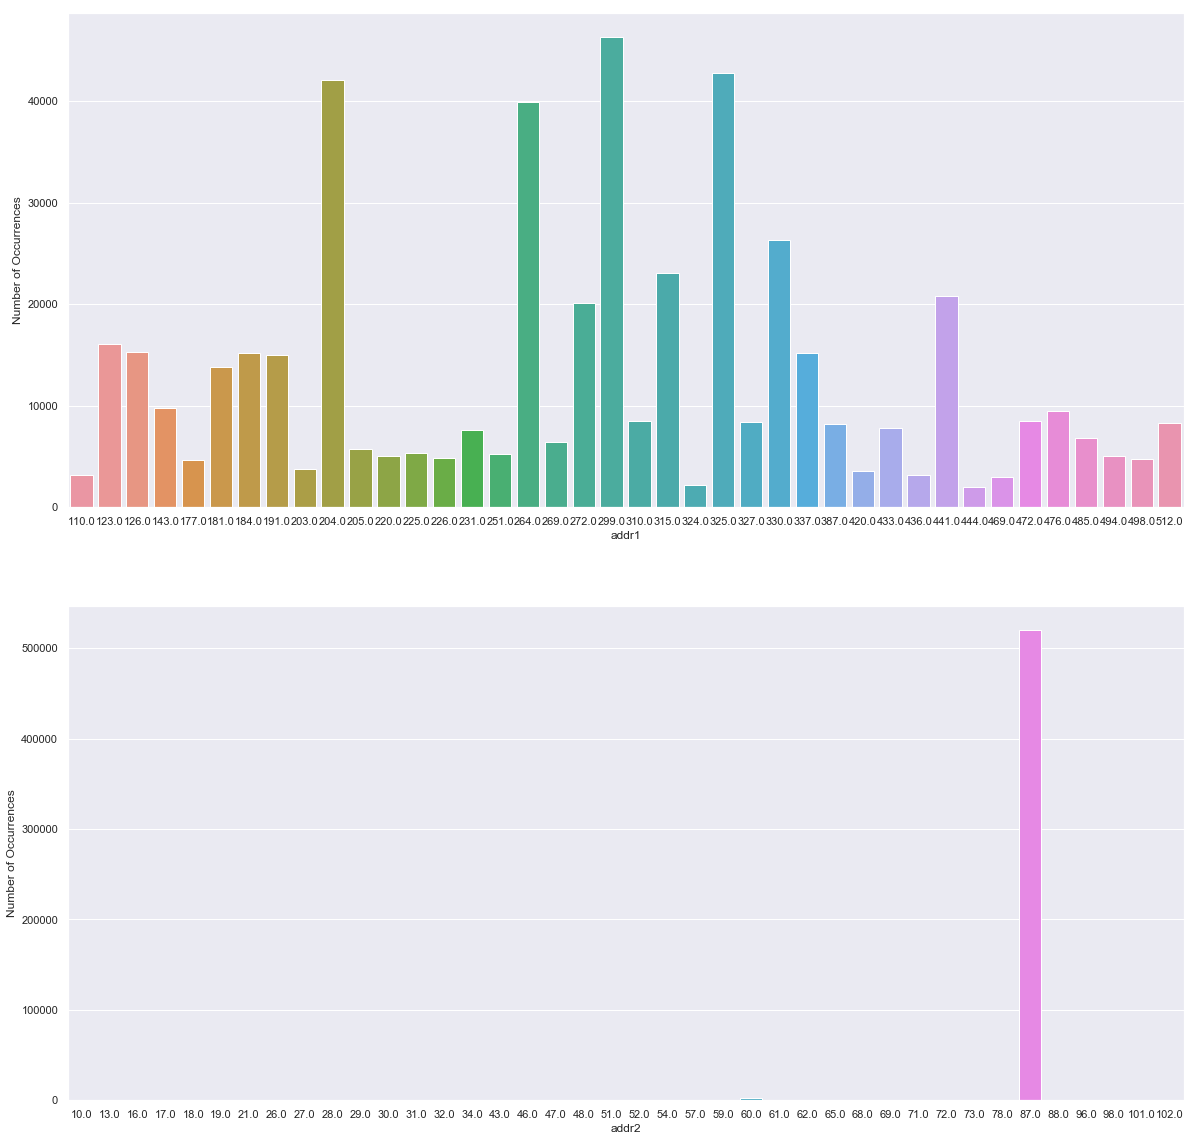

In [222]:
# addr: address addr1, addr2- categorical variable
a4_dims = (20, 20)
fig, axs = plt.subplots(2,1, figsize=a4_dims, squeeze=False)
addr_list=['addr1','addr2']
co=0

for r in range(0,2):
    for c in range(0, 1): 
        feature_count=train_transaction[addr_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=addr_list[co],data=feature_count,errwidth=12,capsize=10,ax=axs[r][c])
        ax.set_xlabel(addr_list[co])
        ax.set_ylabel('Number of Occurrences')
        co+=1

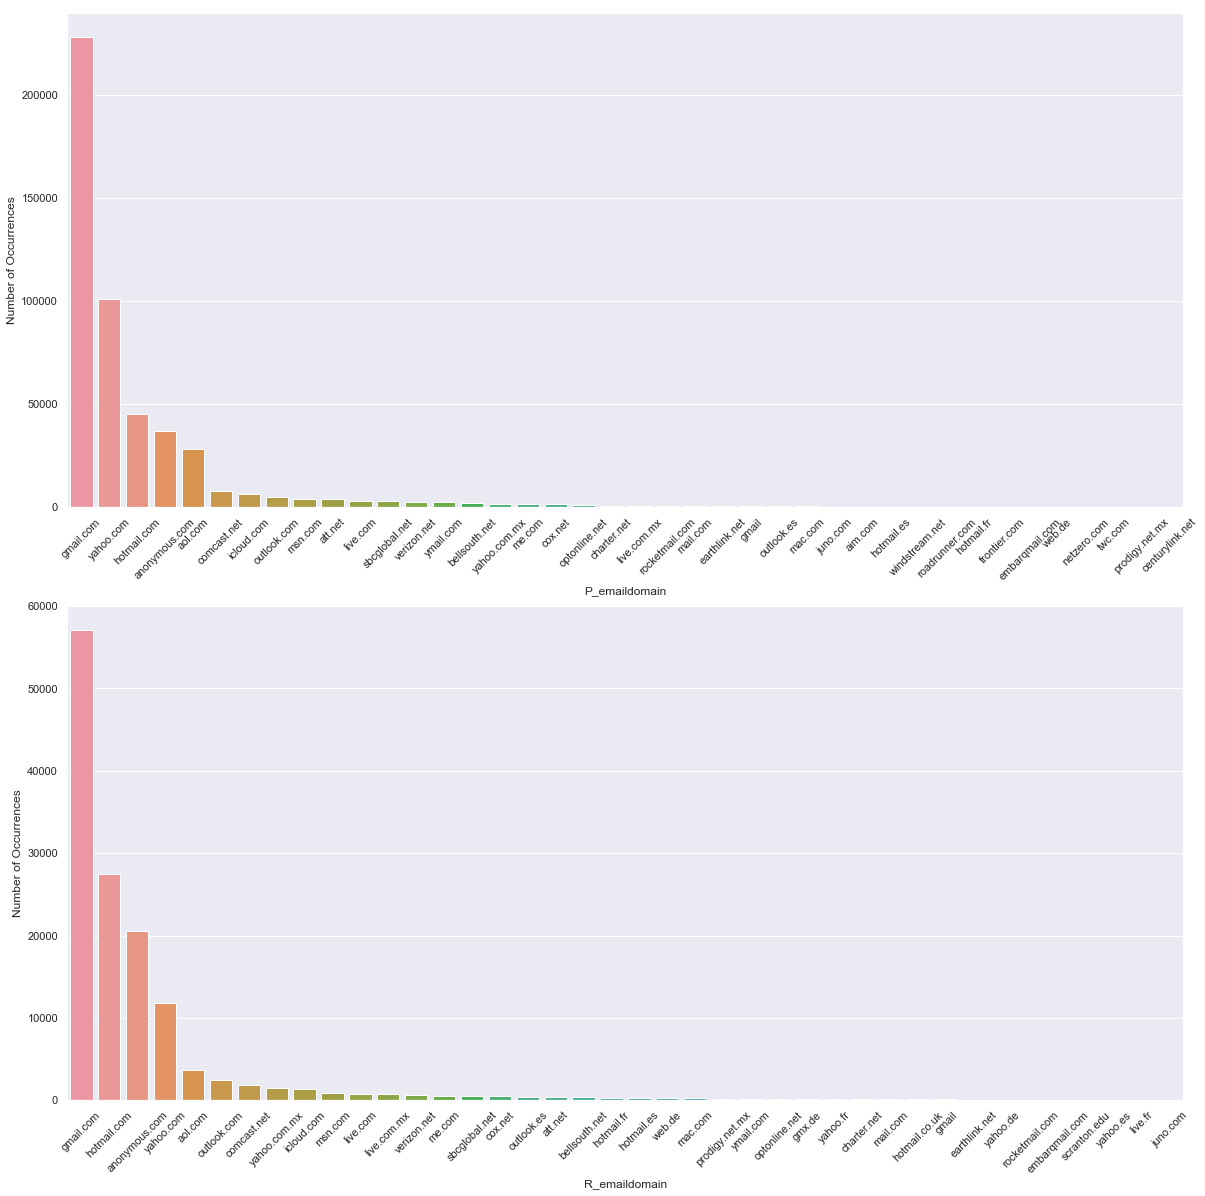

In [223]:
#P_ and (R__) emaildomain: purchaser and recipient email domain its categorical
#print(train['P_emaildomain'].value_counts())
a4_dims = (20, 20)
fig, axs = plt.subplots(2,1, figsize=a4_dims, squeeze=False)
addr_list=['P_emaildomain','R_emaildomain']
co=0

for r in range(0,2):
    for c in range(0, 1): 
        feature_count=train_transaction[addr_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=addr_list[co],data=feature_count,errwidth=12,capsize=10,ax=axs[r][c])
        ax.set_xlabel(addr_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1

In [225]:
m_list=['M1','M2','M3','M4','M5','M6','M7','M8','M9']
# check they are caetgorical or not
for col in m_list:
    print("For the " + str(col))
    print(train_transaction[col].value_counts())

For the M1
T    319415
F        25
Name: M1, dtype: int64
For the M2
T    285468
F     33972
Name: M2, dtype: int64
For the M3
T    251731
F     67709
Name: M3, dtype: int64
For the M4
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
For the M5
F    132491
T    107567
Name: M5, dtype: int64
For the M6
F    227856
T    193324
Name: M6, dtype: int64
For the M7
F    211374
T     32901
Name: M7, dtype: int64
For the M8
F    155251
T     89037
Name: M8, dtype: int64
For the M9
T    205656
F     38632
Name: M9, dtype: int64


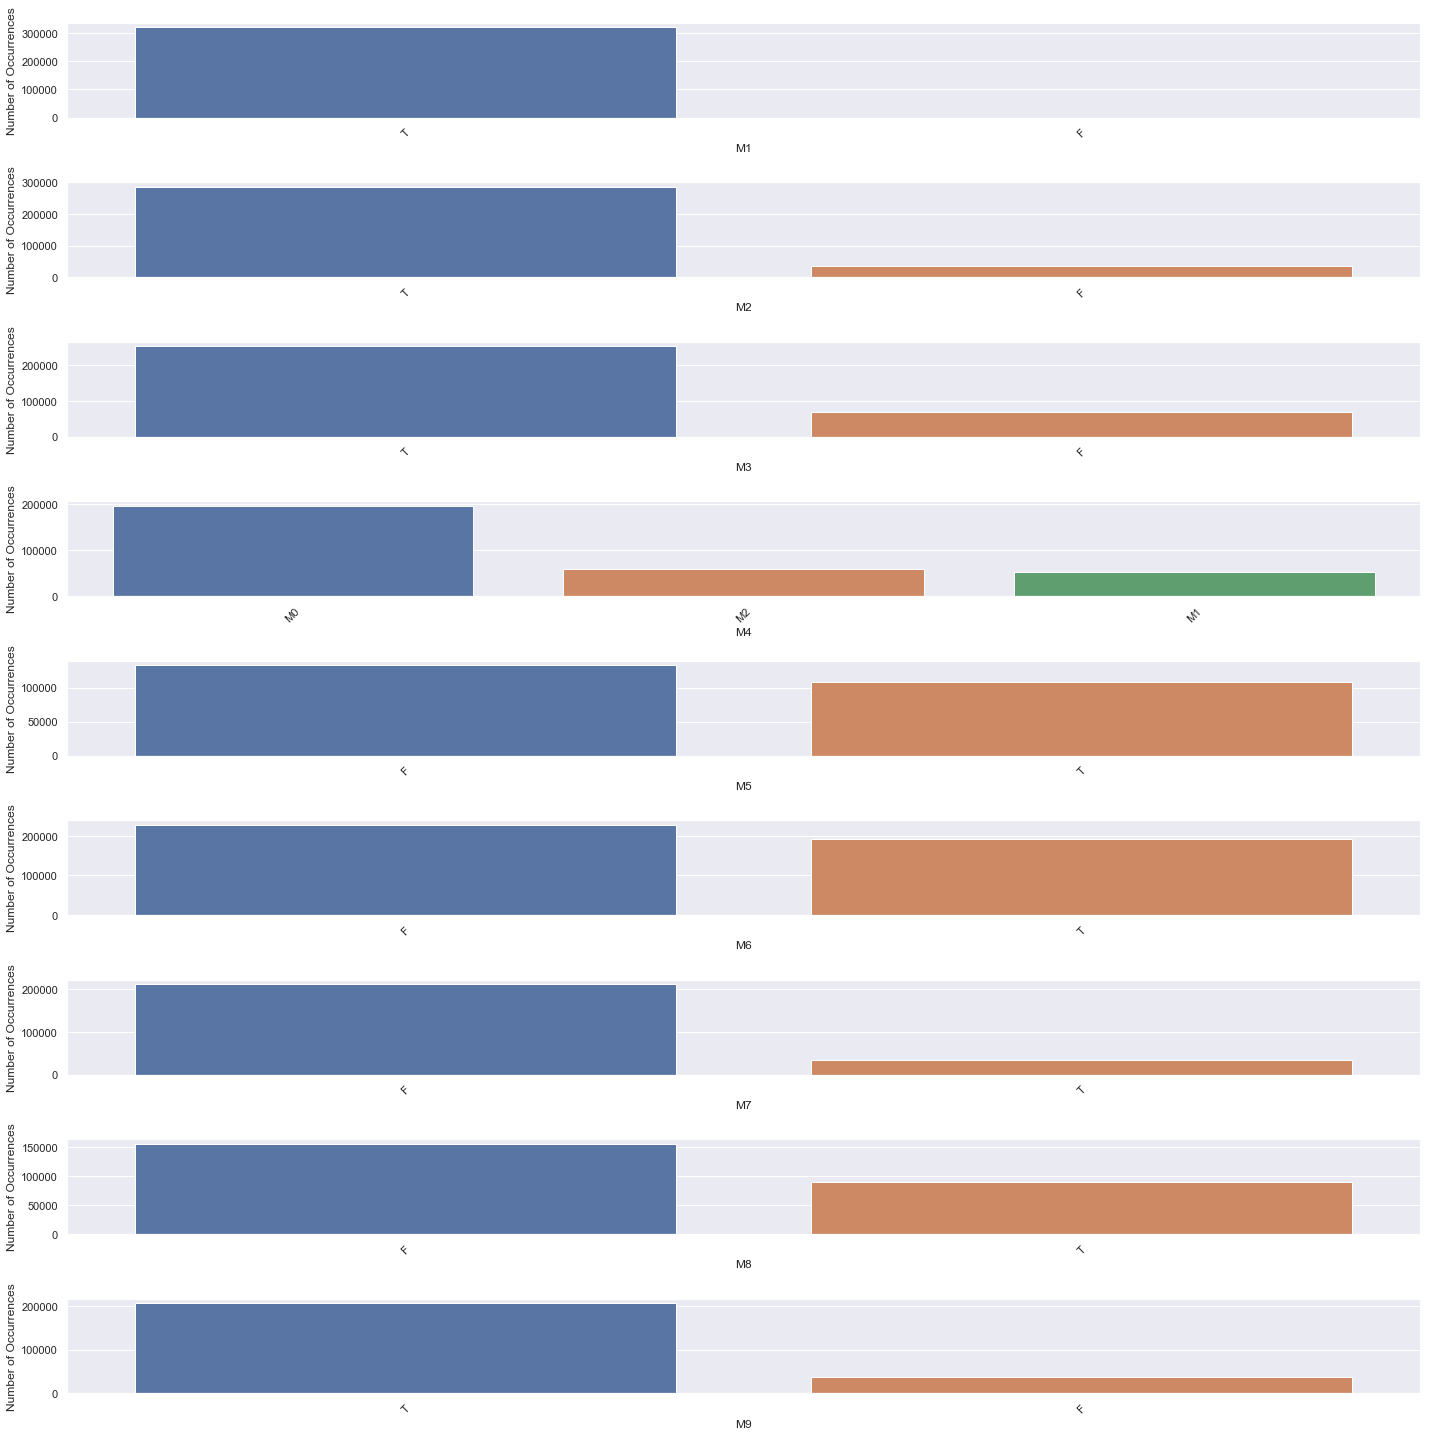

In [226]:
# M1 - M9 categorical variable that need to analyze
# the values are match, such as names on card and address, etc.
a4_dims = (20, 20)
fig, axs = plt.subplots(9,1, figsize=a4_dims, squeeze=False)
co=0
m_list=['M1','M2','M3','M4','M5','M6','M7','M8','M9']
for r in range(0,9):
    for c in range(0, 1): 
        feature_count=train_transaction[m_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=m_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(m_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1
plt.subplots_adjust(hspace = 0.2)
plt.tight_layout()

analysis of train_identity features

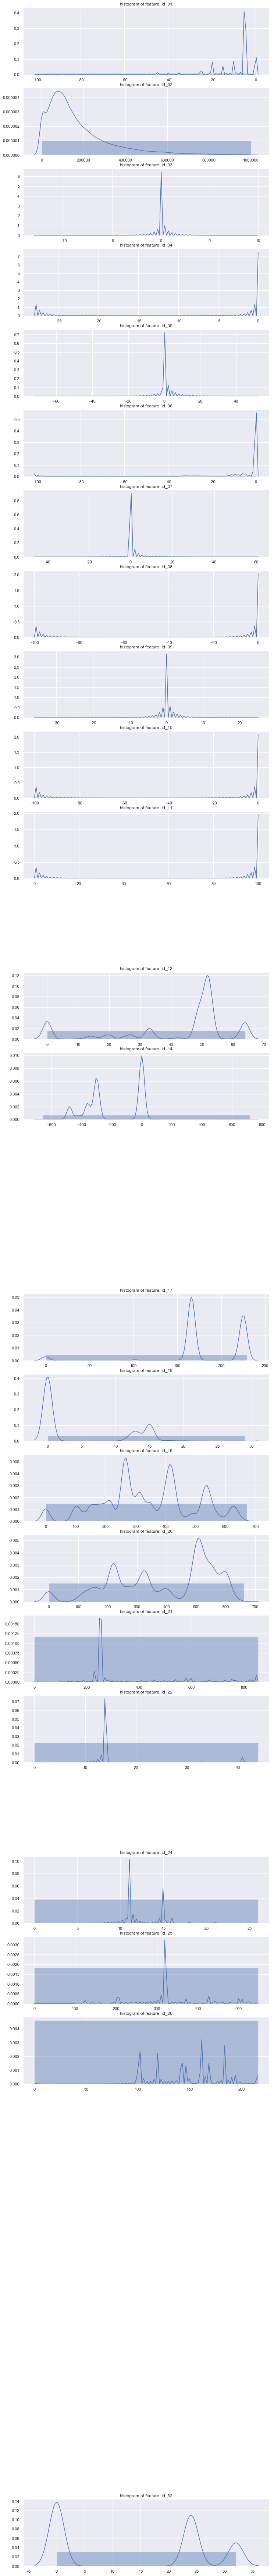

In [214]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,38*4))
gs = gridspec.GridSpec(38, 1)
excludeColumns = [12, 15,16, 23, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38]
for i in range(1, 39):
    if i not in excludeColumns:
        ax = plt.subplot(gs[i-1])
        sns.distplot(train_identity['id_{:02d}'.format(i)].replace(np.nan, 0), bins=1)
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + 'id_{:02d}'.format(i))
plt.show()
plt.tight_layout()

In [238]:
#id12 - id38 as categorical variable
id_list=[]
for i in range(12,39):
    id_list.append('id_{:02d}'.format(i))
print(id_list)

['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


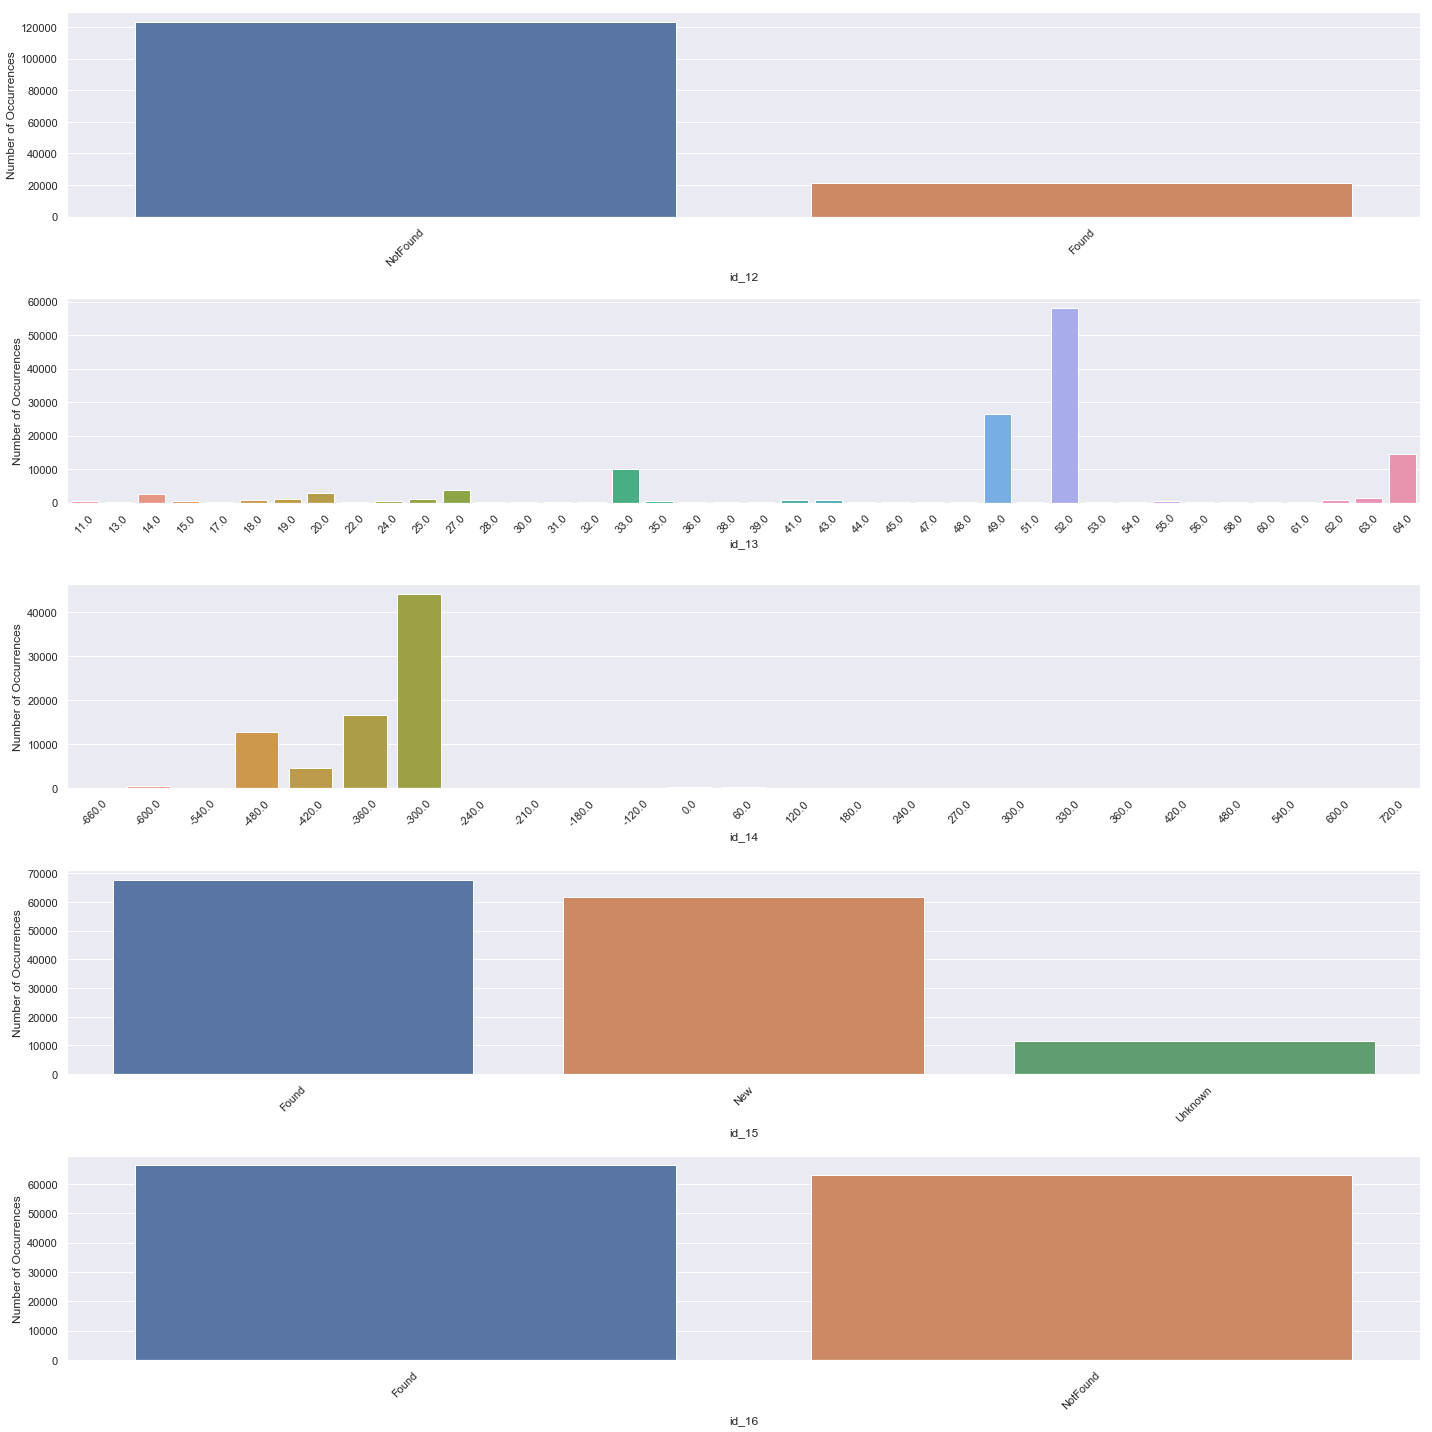

In [239]:
#iterate the id_list and visualize it
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co=0

for r in range(0,5):
    for c in range(0, 1): 
        feature_count=train_identity[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1

plt.tight_layout()

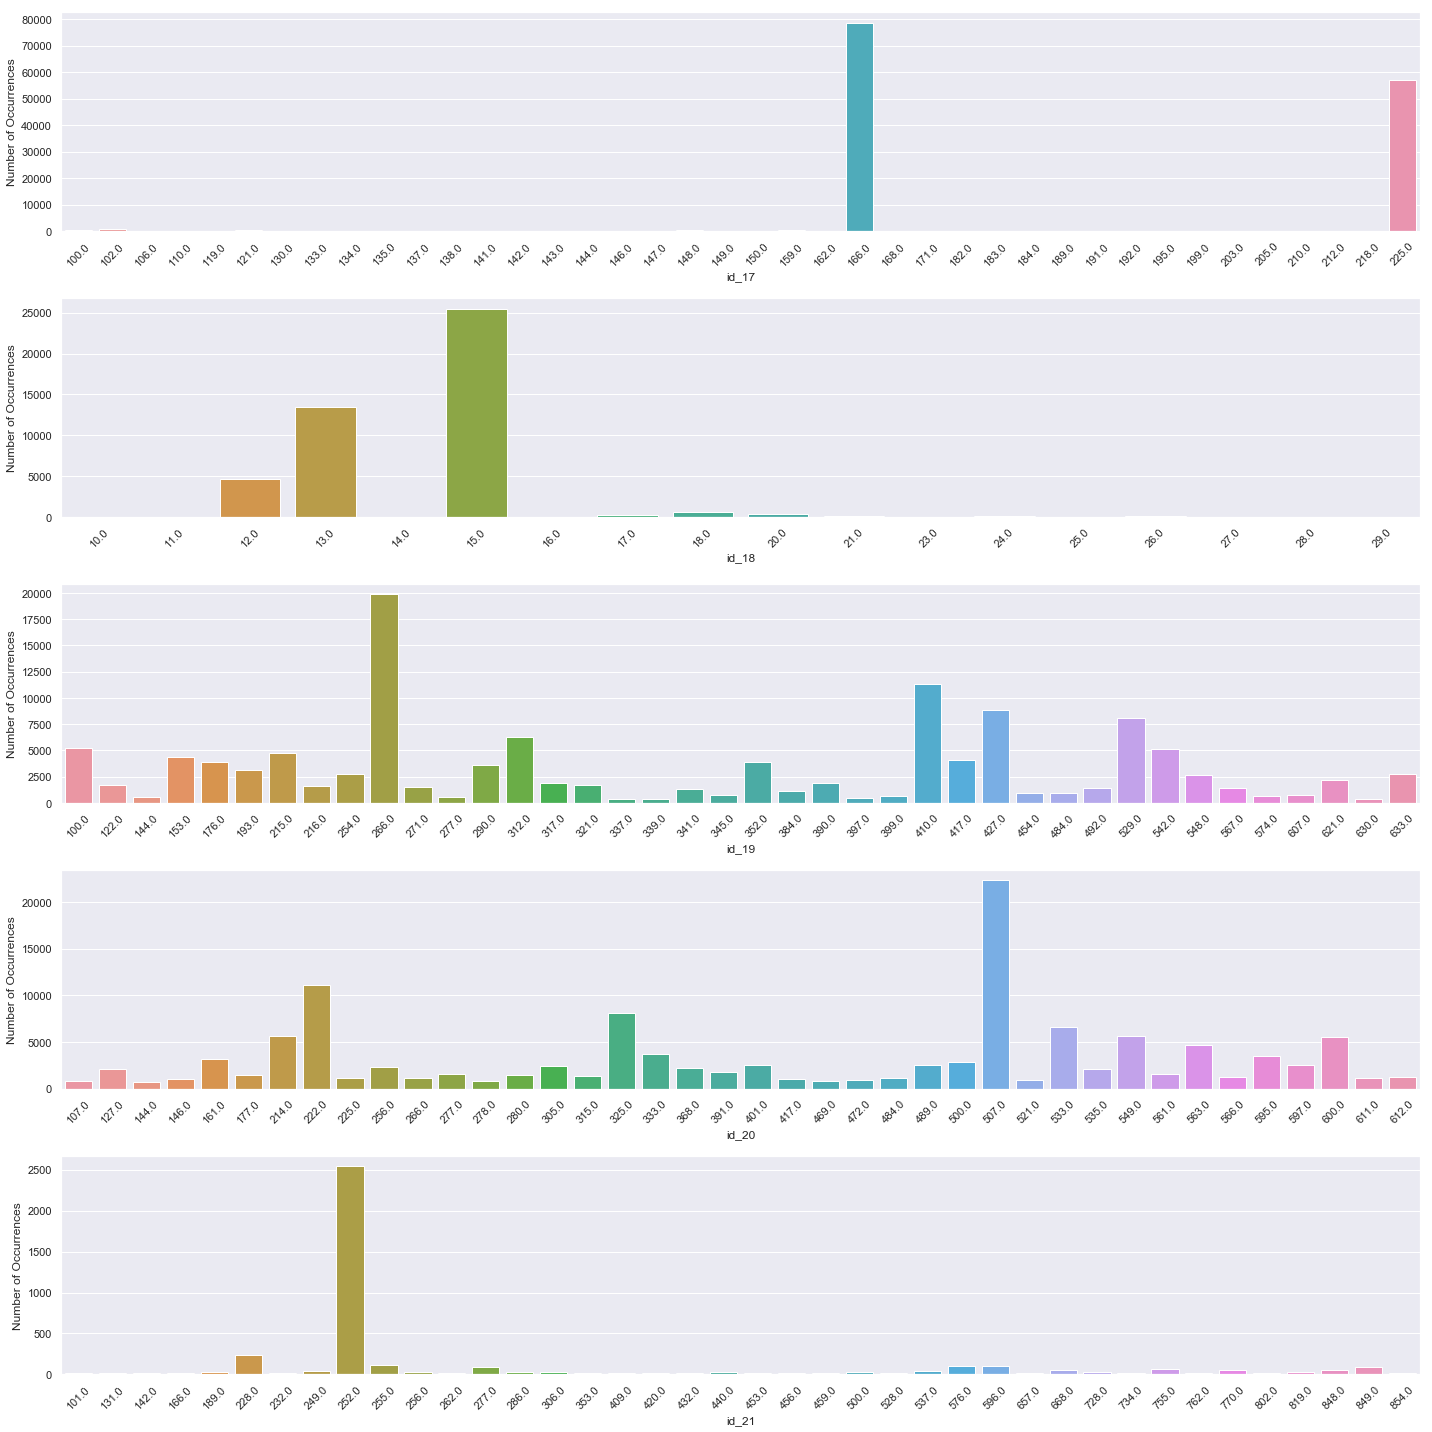

In [240]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co=5

for r in range(0,5):
    for c in range(0, 1): 
        feature_count=train_identity[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1

plt.tight_layout()

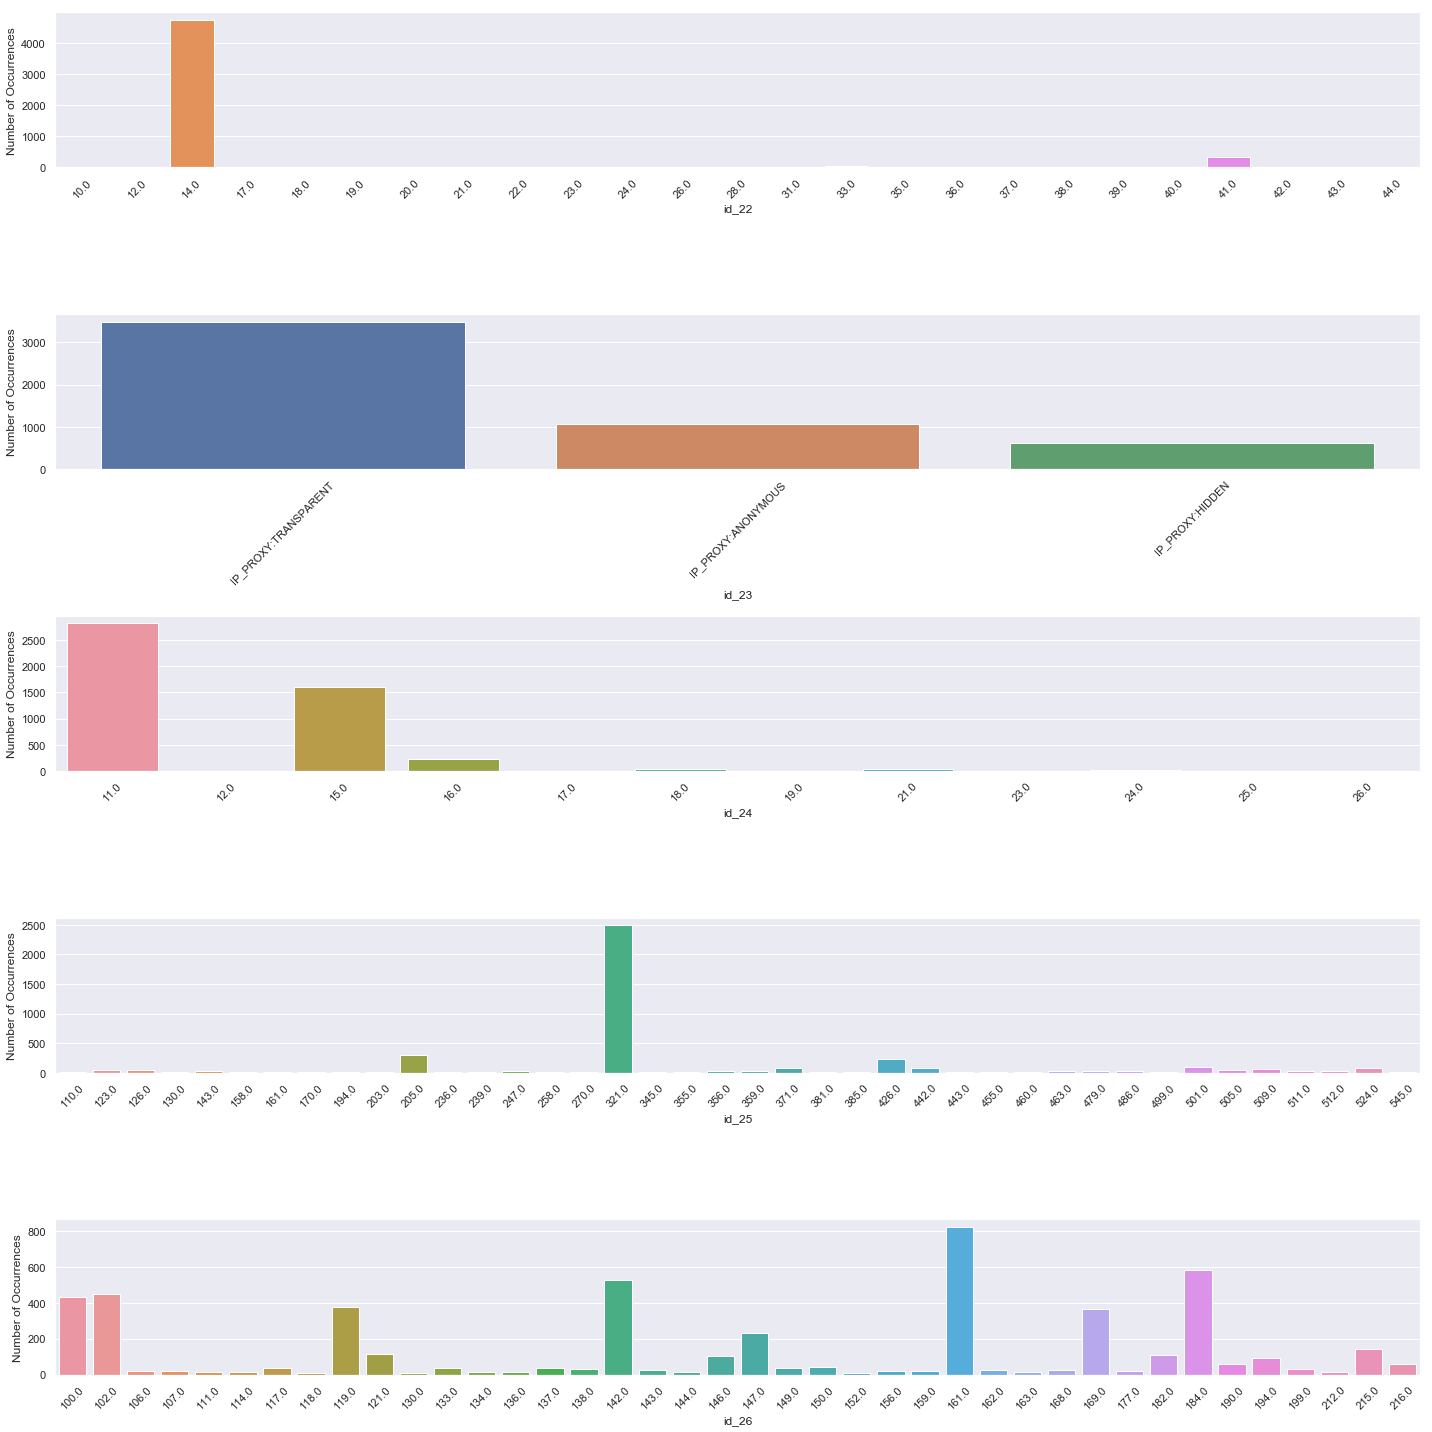

In [241]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co=10

for r in range(0,5):
    for c in range(0, 1): 
        feature_count=train_identity[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1

plt.tight_layout()

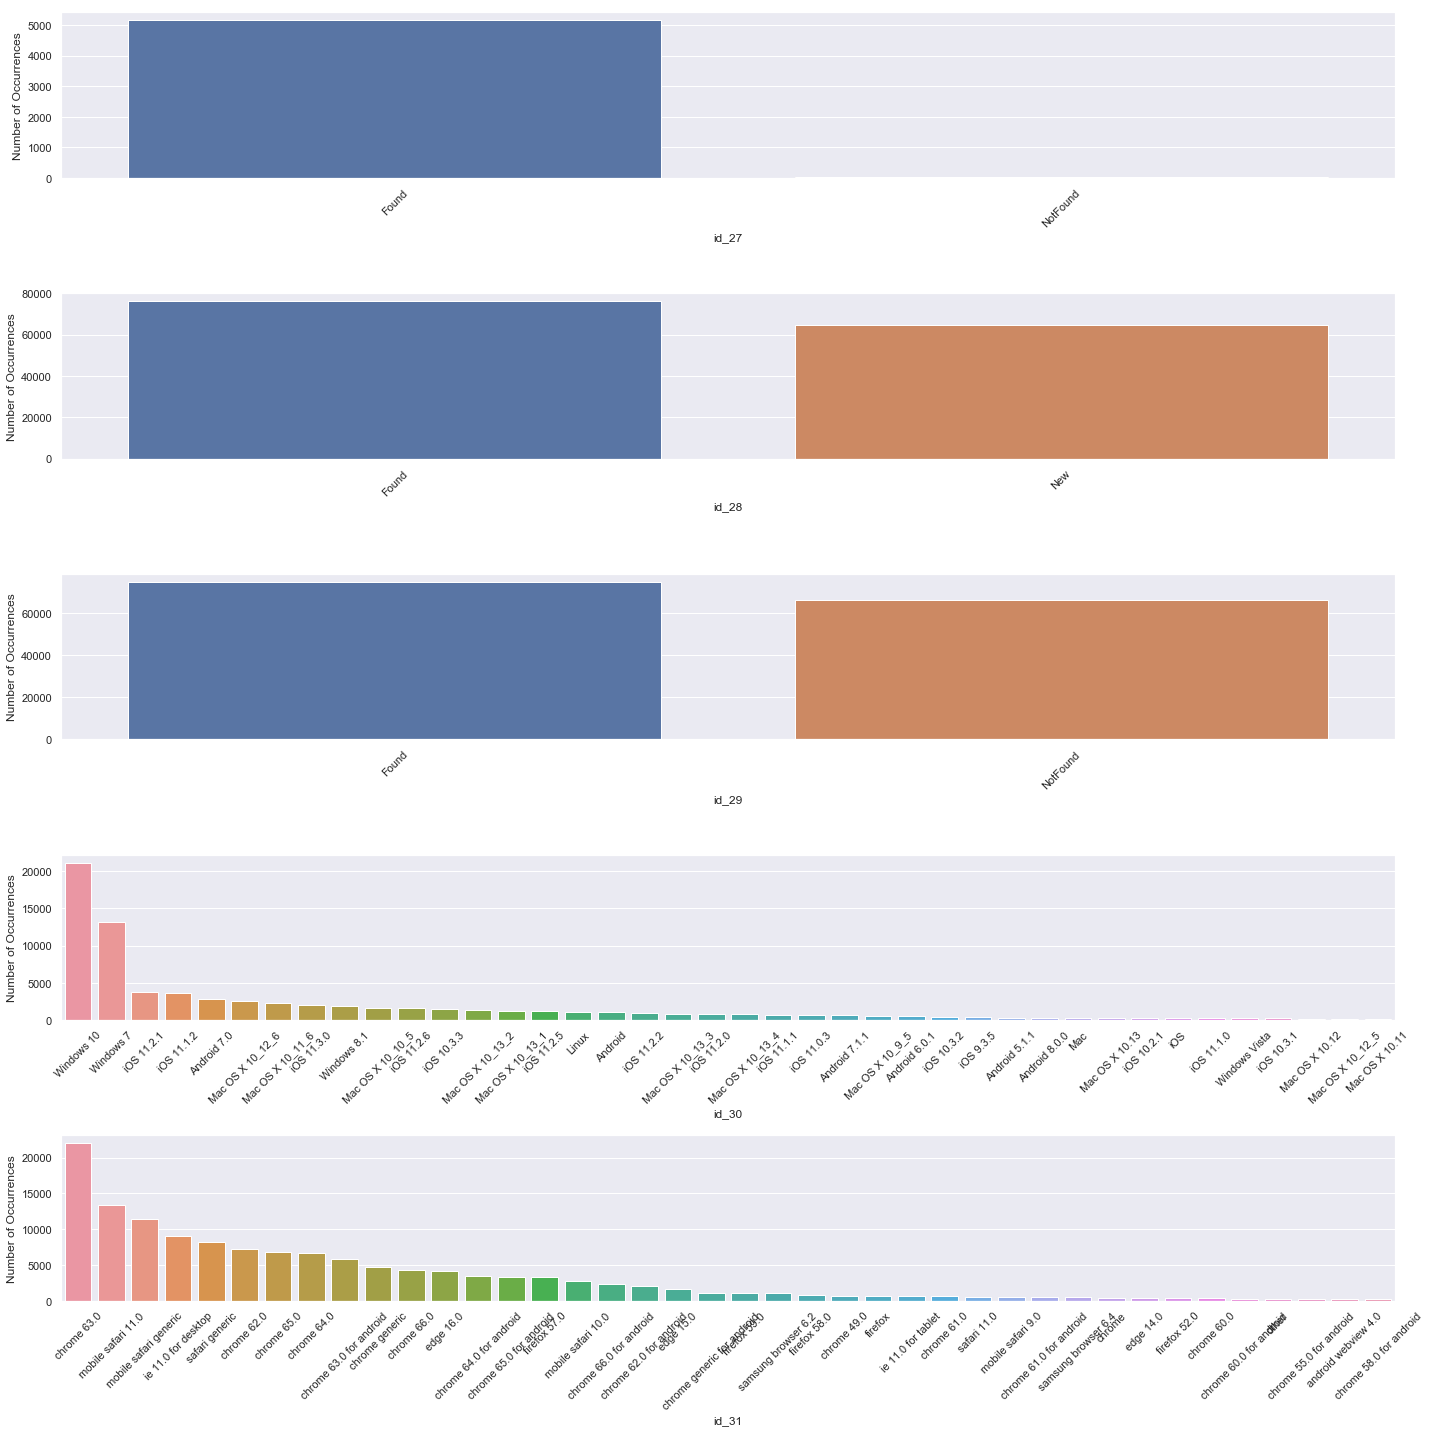

In [242]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co=15

for r in range(0,5):
    for c in range(0, 1): 
        feature_count=train_identity[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count=feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax=sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co+=1

plt.tight_layout()

# Working the Dataset

In [80]:
df_train = train_transaction.merge(train_identity, on="TransactionID", how="left")

In [81]:
assert (df_train.shape[0] == train_transaction.shape[0])

In [82]:
df_train.shape, train_transaction.shape

((590540, 434), (590540, 394))

In [83]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


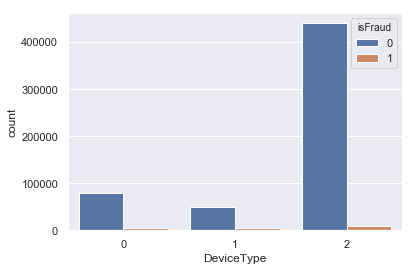

In [229]:
#DeviceType
df_train['DeviceType'].value_counts()
sns.countplot(x='DeviceType',hue='isFraud',data=df_train)

In [84]:
df_test = test_transaction.merge(test_identity, on="TransactionID", how="left")

In [85]:
assert (df_test.shape[0] == test_transaction.shape[0])

In [86]:
df_test.shape, test_transaction.shape

((506691, 433), (506691, 393))

In [87]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Elimination of columns with 80% or more of nan fields

In [88]:
for c in df_train:
    if sum(df_train[c].isnull()) >= 0.8 * df_train.shape[0]:
        print(c)
        df_train.drop(c, axis=1, inplace=True)
        df_test.drop(c, axis=1, inplace=True)

dist2
D6
D7
D8
D9
D12
D13
D14
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V322
V323
V324
V325
V326
V327
V328
V329
V330
V331
V332
V333
V334
V335
V336
V337
V338
V339
id_03
id_04
id_07
id_08
id_09
id_10
id_14
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_30
id_32
id_33
id_34


In [89]:
df_train.shape, df_test.shape

((590540, 360), (506691, 359))

difference in column size as df_test does not include column 'isFraud'

remowe TransactionID and TransactionDT column

In [90]:
df_train.drop('TransactionID', axis=1, inplace=True)
df_train.drop('TransactionDT', axis=1, inplace=True)
df_test.drop('TransactionID', axis=1, inplace=True)
df_test.drop('TransactionDT', axis=1, inplace=True)

In [91]:
df_train.shape, df_test.shape

((590540, 358), (506691, 357))

In [93]:
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [109]:
x_train = df_train.copy()
x_train = x_train.drop('isFraud', axis="columns")
#y_train = df_train['isFraud']

In [111]:
x_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Label Encoding ie. replacement all labels with integers

In [119]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0,x_train.shape[1]):
    if x_train.dtypes[i]=='object':
        print(x_train.columns[i])
        x_train[x_train.columns[i]] = le.fit_transform(x_train[x_train.columns[i]].astype(str))

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_31
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [121]:
for i in range(0,df_test.shape[1]):
    if df_test.dtypes[i]=='object':
        print(df_test.columns[i])
        df_test[df_test.columns[i]] = le.fit_transform(df_test[df_test.columns[i]].astype(str))

df_test.head()

replace NaN with mediam values

In [137]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
x_train = clean_inf_nan(x_train)
df_test = clean_inf_nan(df_test ) # replace all nan,inf,-inf to nan so it will be easy to replace
for i in x_train.columns:
    x_train[i].fillna(x_train[i].median(),inplace=True) # fill with median because mean may be affect by outliers.
#X.isna().sum().sum()
for i in df_test.columns:
    df_test[i].fillna(df_test[i].median(),inplace=True)

In [138]:
x_train.shape

(590540, 357)

In [139]:
x_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,13926,361.0,150.0,1,142.0,1,315.0,87.0,...,472.0,2,2,103,2,2,2,2,2,1742
1,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,472.0,2,2,103,2,2,2,2,2,1742
2,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,472.0,2,2,103,2,2,2,2,2,1742
3,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,472.0,2,2,103,2,2,2,2,2,1742
4,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,144.0,1,1,124,1,0,1,1,1,954


# Model Building

In [140]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(x_train, y_train)
logistic.score(x_train, y_train)

0.964772919700613

In [156]:
y_train_pred = logistic.predict(x_train)

In [168]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_test, pred):

    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

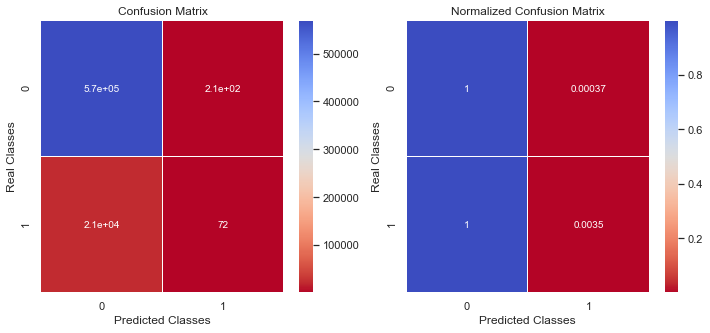

---Classification Report---
             precision    recall  f1-score   support

          0       0.97      1.00      0.98    569877
          1       0.25      0.00      0.01     20663

avg / total       0.94      0.96      0.95    590540



In [169]:
plot_confusion_matrix(y_train, y_train_pred)

In [162]:
submission=pd.DataFrame()
submission['TransactionID']=test_transaction['TransactionID']

In [144]:
test_res = logistic.predict(df_test)

In [147]:
test_res=pd.DataFrame(test_res)

In [164]:
test_res.head()

,0
0,0
1,0
2,0
3,0
4,0


In [149]:
submission['isFraud'] = test_res

In [150]:
submission.head()

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0


In [155]:
fraud = submission.loc[submission['isFraud'] == 1]
non_fraud = submission.loc[submission['isFraud'] == 0]
len(fraud), len(non_fraud)

(634, 506057)

In [151]:
submission.to_csv("submission_lr.csv")